In [1]:
from json import loads
import pandas as pd
from datetime import datetime
import sys
import os

In [2]:

script_path = os.path.abspath("../")
sys.path.append(script_path)

from utils import generic_bar_graph, generic_distribution_plot, generic_plot_boxplots

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [ ]:
%load_ext autoreload
%autoreload 2

# Carregando e configurando o dataset

In [4]:
df = pd.read_csv('../csv_datasets/data_from_all_players_tournaments_seasons_dataset.csv')

In [ ]:
df.head()

## Removendo colunas desnecessárias

In [5]:
df.drop('Unnamed: 0', axis=1, inplace=True)

## Renomeando colunas

In [6]:
df.rename(columns={'points': 'heatmap'}, inplace=True)

## Extraindo dados dos jogadores para o Dataset

In [7]:
df['player'] = df['player'].apply(eval)

In [8]:
df_players = pd.json_normalize(df['player'])

In [9]:
df = pd.concat([df, df_players], axis=1)

In [ ]:
df.head(1)

In [10]:
df = df[
    [
        'positive',
        'negative',
        'positions',
        'heatmap',
        'matches',
        'statistics',
        'team',
        'season',
        'tournament',
        'name',
        'position',
        'height',
        'preferredFoot',
        'proposedMarketValue',
        'contractUntilTimestamp',
        'team.shortName',
        'team.tournament.name',
        'team.tournament.category.name',
        'team.tournament.category.country.name',
        'id',
        'retired',
        'dateOfBirthTimestamp',
        'deceased'
    ]
].copy()

In [11]:
df.rename(columns={'team.shortName': 'current_team',
                   'team.tournament.name': 'current_team_tournament', 
                   'team.tournament.category.name': 'current_team_tournament_category',
                   'team.tournament.category.country.name': 'current_team_country',
                   'id': 'player_id'}, inplace=True)

## Extraindo dados dos times da temporada do jogador

In [12]:
df['team'] = df['team'].apply(eval)

In [13]:
df_team = pd.json_normalize(df['team'])

In [14]:
df_team.rename(columns={'name': 'season_team',
                   'shortName': 'season_team_shortname', }, inplace=True)

In [15]:
df = pd.concat([df, df_team], axis=1)

In [16]:
df = df.iloc[:, :26]

In [ ]:
df.head(1)

In [17]:
df.drop(['team', 'slug'], axis=1, inplace=True)

## Extraindo dados das estatisticas para o Dataset

In [18]:
df['statistics'] = df['statistics'].apply(eval)

In [19]:
df_statistics = pd.json_normalize(df['statistics'])

In [20]:
df = pd.concat([df, df_statistics], axis=1)

In [ ]:
df.head()

In [21]:
df.drop('statistics', axis=1, inplace=True)

## Criando algumas colunas para auxiliar na análise

In [22]:
def calculate_age(birth_timestamp):
    age = None
    if not pd.isna(birth_timestamp):

        birth_date = datetime.fromtimestamp(birth_timestamp)

        current_date = datetime(2025, 3, 20, 21, 4)
        
        age = current_date.year - birth_date.year - ((current_date.month, current_date.day) < (birth_date.month, birth_date.day))
    
    return age

In [23]:
df['age'] = df['dateOfBirthTimestamp'].apply(calculate_age)

# Analise exploratória

## Identificando valores nulos - Dados dos jogadores

In [ ]:
df.iloc[:,:22].info(verbose=True, show_counts=True)

#### Matches e Heatmap

Explicações para valores nulos

- heatmap: Jogadores que jogaram menos de um jogo ou estão aposentados
- matches: Mesma coisa que o heatmap

In [ ]:
df[df['heatmap'].isnull()].head()

In [ ]:
df[df['heatmap'].isnull()]['minutesPlayed'].value_counts()

In [ ]:
df[(df['heatmap'].isnull()) & (df['minutesPlayed'] == 90)]

In [ ]:
df[df['heatmap'].isnull()]['retired'].value_counts()

In [ ]:
df[(df['heatmap'].isnull()) & (df['retired'].isna())].head()

In [ ]:
df[(df['heatmap'].isnull()) & (~df['matches'].isnull())].head()

#### Position

São poucos jogadores, que jogaram poucos minutos e geralmente são jovens

In [ ]:
df[df['position'].isnull()]['minutesPlayed']

In [ ]:
df[df['position'].isnull()][['name', 'age', 'player_id']]

### Jogadores sem idade

Também o padrão se repete, são jogadores que jogaram muito pouco e não há muitas informações sobre eles

In [ ]:
len(df[df['age'].isnull()])

In [ ]:
df[df['age'].isnull()]['minutesPlayed'].value_counts()

### Jogadores mortos

Existem nove jogadores que faleceram

In [ ]:
df['deceased'].value_counts()

In [ ]:
df[df['deceased'] == True]

### height

Aparentemente não há um padrão para a altura não aparecer em alguns jogadores. Ela será preenchida na etapa de pré processamento

In [ ]:
df['height'].info(verbose=True, show_counts=True)

In [ ]:
grouped_data = df[df['height'].isnull()].groupby('tournament').count().reset_index().sort_values('name')

In [ ]:
generic_bar_graph(categories=grouped_data['tournament'], values=grouped_data['name'], title='Jogadores sem altura por liga', x_label='Número de jogadores', y_label='Liga', x_rotation=90)

In [ ]:
grouped_data = df[df['height'].isnull()].groupby(['tournament', 'season'])['minutesPlayed'].max().reset_index().sort_values('minutesPlayed')

In [ ]:
generic_bar_graph(categories=grouped_data['tournament'], values=grouped_data['name'], title='Jogadores sem altura por liga', x_label='Número de jogadores', y_label='Liga', x_rotation=90)

In [ ]:
stacked_data = grouped_data.pivot_table(index='season', columns='tournament', values='minutesPlayed')

In [ ]:
stacked_data

In [ ]:
import matplotlib.pyplot as plt

stacked_data.plot(kind='bar', stacked=True, figsize=(12, 6), colormap="viridis")

# Personalizar o gráfico
plt.title('Distribuição dos Minutos Jogados por Temporada e Liga')
plt.xlabel('Temporada')
plt.ylabel('Minutos Jogados')
plt.legend(title='Liga', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### preferredFoot

Parece que ocorreu um problema na coleta destes dados. Apenas para estes jogadores, vou refazer as coletas de dados ou posso inserir a moda nessa caso

In [ ]:
df[df['preferredFoot'].isnull()][['tournament', 'season', 'name', 'player_id']]

### retired and deceased

Alguns jogadores realmente não tem essa informação. Estes serão considerados jogadores normais

In [ ]:
df[df['deceased'].isnull()][['tournament', 'season', 'name', 'player_id']]

### Jogadores que não jogaram nenhum minuto na temporada

In [ ]:
len(df[df['minutesPlayed'] == 0])

### Jogadores aposentados

In [ ]:
len(df[df['retired'] == True])

## Identificando valores nulos - Estatisticas dos jogadores

In [ ]:
df.iloc[:,22:].info(verbose=True, show_counts=True)

### assists

Realmente parece que alguns jogadores não tem essa característica computada. Vou preencher esses valores faltantes na etapa de pré-processamento

In [ ]:
df[df['assists'].isnull()]['position'].value_counts()

In [ ]:
df[df['assists'].isnull()].head(5)

### goalKicks

Não sei se essa variável é tão util. Relacionada ao número de tiros de meta de um jogador. Grande maioria não tem por que não bate tiro de meta

In [ ]:
df[(df['goalKicks'] > 0)][['tournament', 'season', 'name', 'player_id' ,'goalKicks']].head(5)

In [ ]:
df[(df['goalKicks'] > 0) & (df['position'] == 'G')][['tournament', 'season', 'name', 'goalKicks']].head(5)

In [ ]:
df[~df['goalKicks'].isnull()].head(5)

### ballRecovery e goalsPrevented

Talvez seja uma estatistica que não guardam muito. Nem todo jogador deve ter esse tipo de ação no jogo

### expectedAssists e expectedGoals

Aparentemente, nem todos os jogadores tem essa estatística calculada. Melhor analisar uma estratética para imputar isso no pré-processamento

In [ ]:
df[df['expectedAssists'].isnull()][['tournament', 'season', 'player_id', 'name']].head()

In [ ]:
df[(df['expectedAssists'].isnull()) & (df['assists'] > 0)][['tournament', 'season', 'player_id', 'name']]

In [ ]:
len(df[df['expectedAssists'].isnull()]['tournament'].unique())

In [ ]:
len(df[df['expectedGoals'].isnull()]['tournament'].unique())

In [ ]:
grouped_data = grouped_data = df[df['expectedAssists'].isnull()].groupby(['tournament'])['minutesPlayed'].max().reset_index().sort_values('minutesPlayed')

In [ ]:
generic_bar_graph(categories=grouped_data['tournament'], values=grouped_data['minutesPlayed'], title='Jogadores sem Xa', x_label='Número máximo de minutos em campo', y_label='Liga', x_rotation=90)

In [ ]:
grouped_data = grouped_data = df[df['expectedAssists'].isnull()].groupby(['tournament'])['assists'].max().reset_index().sort_values('assists')

In [ ]:
generic_bar_graph(categories=grouped_data['tournament'], values=grouped_data['assists'], title='Jogadores sem Xa', x_label='Número máximo de assistencias', y_label='Liga', x_rotation=90)

In [ ]:
df[(df['expectedAssists'].isnull()) & (df['assists'] > 20)][['tournament', 'season', 'player_id', 'name', 'assists']]

## Analisando distribuição e outliers de variáveis

In [25]:
df_analisys = df[
    ((df['deceased'].isnull()) | (df['deceased'] == False))
    &
    (~df['heatmap'].isnull())
    &
    (~df['position'].isnull())
    &
    (~df['age'].isnull())
].copy()

### Número de jogadores que aparecem mais de uma vez

A maioria dos jogadores aparece mais de uma vez no dataset. Alguns deles possuem dados apenas de uma temporada.

Para estes que aparecem apenas uma vez, eles podem ficar com menos dados nas agregações comparados aos que aparecem mais de uma vez.

Tem outro cenário, que seria o de simular quando jogadores entraram na esteira do algoritmo sem possuir dados anteriores. Seria um teste meio que em "produção"

In [ ]:
df_two_seasons = df_analisys.groupby('player_id')['name'].size().reset_index()

In [ ]:
len(df_analisys)

In [ ]:
df_two_seasons['name'].value_counts().reset_index()

In [ ]:
len(df_analisys[df_analisys['season'].isin(['23_24', '2024'])])

In [ ]:
len(df_analisys[df_analisys['season'].isin(['22_23', '2023'])])

### Analisando quais jogadores trocaram de time na mesma temporada

In [ ]:
df_transfer = df_analisys.groupby(['player_id', 'season'])['season_team'].nunique().reset_index()

In [ ]:
df_transfer[(df_transfer['season_team'] > 1)]

In [ ]:
df_transfer[(df_transfer['season_team'] > 1) & (df_transfer['season'].isin(['23_24', '2024']))]

In [ ]:
df_analisys[df_analisys['player_id'] == 15190]

### Filtrando apenas a última temporada

In [26]:
df_analisys = df_analisys[df_analisys['season'].isin(['2024', '23_24'])]

### Características dos jogadores

In [27]:
df_player_characteristics = df_analisys[['positions','heatmap','matches', 'season', 'tournament', 'name', 'position', 'height', 
 'preferredFoot', 'proposedMarketValue', 'contractUntilTimestamp', 
 'current_team', 'current_team_tournament', 'current_team_tournament_category', 
 'current_team_country', 'player_id', 'retired', 'age', 
 'deceased', 'season_team', 'season_team_shortname']].copy()

In [ ]:
df_player_characteristics.info(verbose=True)

Das variáveis acima, o que eu acho que pode ser interessante para o modelo:

- heatmap
- matches
- position
- height
- preferredFoot
- age

#### Analisando distribuição das variáveis

In [ ]:
generic_distribution_plot(df_player_characteristics, ['matches', 'height', 'age'], graphs_per_row=3, bins_dict={'matches': 20, 'height': 20, 'age': 5})

#### Analisando valores incomuns na variável age

Um jogador está com a idade incorreta. Ele será removido

In [ ]:
generic_plot_boxplots(df_player_characteristics, ['age'])

In [ ]:
print(df[df['age'] > 1000]['dateOfBirthTimestamp'])

In [ ]:
df[df['age'] > 1000]

In [ ]:
df_player_characteristics = df_player_characteristics[df_player_characteristics['age'] < 60]

In [ ]:
generic_plot_boxplots(df_player_characteristics, ['age'])

In [ ]:
df_player_characteristics['age'].describe()

In [ ]:
df_player_characteristics[df_player_characteristics['age'] == 15]

#### Analisando outliers para a variável matches

Esta variável não tem outliers fora do iterquartil range, mas é interessante analisar posteriormente o impacto de poucos jogos nas estatisticas

In [ ]:
generic_plot_boxplots(df_player_characteristics, ['matches'])

In [ ]:
df_player_characteristics['matches'].describe()

#### Analisando outliers para a vairável height

Os valores, mesmo sendo outliers, são genuinos para essa variável. Fiz uma análise da média de altura por posição, o que pode ser útil posteriormente para pós processamento

In [ ]:
generic_plot_boxplots(df_player_characteristics, ['height'])

In [ ]:
df_player_characteristics['height'].describe()

In [ ]:
df_mean_height_per_position = df_player_characteristics.groupby(['position'])['height'].mean().reset_index()

In [ ]:
df_mean_height_per_position

In [ ]:
generic_bar_graph(categories=df_mean_height_per_position['position'], values=df_mean_height_per_position['height'], title='Média de Altura Por Posição', x_label='Posição', y_label='Média de Altura', x_rotation=90)

In [ ]:
df_mean_height_per_position = df_player_characteristics.groupby(['position'])['height'].median().reset_index()

In [ ]:
df_mean_height_per_position

In [ ]:
generic_bar_graph(categories=df_mean_height_per_position['position'], values=df_mean_height_per_position['height'], title='Mediana de Altura Por Posição', x_label='Posição', y_label='Mediana de Altura', x_rotation=90)

#### Analisando número de valores nas variáveis preferredFoot e position

O pé preferido do jogador terá algum valor preditivo?

As posições aqui não são especificas, apenas genéricas onde o jogador ocupa no campo

In [ ]:
preferred_foot_grouped_data = df_player_characteristics.groupby(['preferredFoot']).size().reset_index()

In [ ]:
preferred_foot_grouped_data

In [ ]:
generic_bar_graph(categories=preferred_foot_grouped_data['preferredFoot'], values=preferred_foot_grouped_data[0], title='Pé preferido do jogador', x_label='Pé', y_label='Contagem', x_rotation=90)

In [ ]:
position_grouped_data = df_player_characteristics.groupby(['position']).size().reset_index().sort_values(0)

In [ ]:
generic_bar_graph(categories=position_grouped_data['position'], values=position_grouped_data[0], title='Número de jogadores por posição', x_label='Posição', y_label='Contagem', x_rotation=90)

#### Decodificando o heatmap

In [28]:
df_player_characteristics[['heatmap', 'player_id', 'season', 'tournament', 'name']]

,heatmap,player_id,season,tournament,name
0,"[{'x': 30, 'y': 10, 'count': 1}, {'x': 30, 'y'...",814221,23_24,2_bundesliga,Manuel Feil
1,"[{'x': 72, 'y': 7, 'count': 1}, {'x': 72, 'y':...",1085304,23_24,2_bundesliga,Marco Pledl
2,"[{'x': 28, 'y': 51, 'count': 2}, {'x': 28, 'y'...",845653,23_24,2_bundesliga,Carlo Sickinger
3,"[{'x': 73, 'y': 32, 'count': 1}, {'x': 73, 'y'...",50968,23_24,2_bundesliga,Terrence Boyd
4,"[{'x': 18, 'y': 28, 'count': 1}, {'x': 18, 'y'...",1000541,23_24,2_bundesliga,Andi Hoti
...,...,...,...,...,...
22182,"[{'x': 81, 'y': 45, 'count': 1}, {'x': 81, 'y'...",838640,23_24,pro_league,Wilfried Kanga
22183,"[{'x': 68, 'y': 89, 'count': 4}, {'x': 68, 'y'...",902987,23_24,pro_league,Loïc Lapoussin
22184,"[{'x': 21, 'y': 87, 'count': 1}, {'x': 21, 'y'...",149592,23_24,pro_league,Jacob Barrett Laursen
22185,"[{'x': 21, 'y': 16, 'count': 1}, {'x': 21, 'y'...",247471,23_24,pro_league,Casper Nielsen


In [ ]:
from json import loads, dumps

In [ ]:
data = df_player_characteristics['heatmap'][0]

In [29]:
heatmap_data = pd.DataFrame(data)

NameError: name 'data' is not defined

In [ ]:
heatmap_matrix = heatmap_data.pivot_table(index='x', columns='y', values='count', fill_value=0)

In [ ]:
heatmap_matrix

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Criando dados de exemplo
data = pd.DataFrame(np.random.random((5,5)), columns=["a","b","c","d","e"])

# Criando o heatmap básico
sns.heatmap(heatmap_matrix)

# Exibindo o gráfico
plt.show()

In [43]:
import numpy as np

def create_heatmap_matrix(data):
    heatmap_matrix = np.zeros((101, 101),  dtype=np.uint8)

    for value in data:
        heatmap_matrix[value['x'], value['y']] = value['count']

    return heatmap_matrix

In [ ]:
import cv2

def detect_key_points_heatmap(data):
    sift = cv2.SIFT_create()

    keypoints, descritores = sift.detectAndCompute(data, None)

    imagem_com_keypoints = cv2.drawKeypoints(data, keypoints, data)

    return imagem_com_keypoints

In [32]:
df_player_characteristics['heatmap'] = df_player_characteristics['heatmap'].apply(eval)

In [44]:
df_player_characteristics['heatmap_matrix'] = df_player_characteristics['heatmap'].apply(create_heatmap_matrix)

In [57]:
df_player_characteristics['heatmap_matrix_key_points'] = df_player_characteristics['heatmap_matrix'].apply(detect_key_points_heatmap)

In [59]:
df_player_characteristics['heatmap_matrix_key_points'] = df_player_characteristics['heatmap_matrix_key_points'].apply(lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2GRAY))

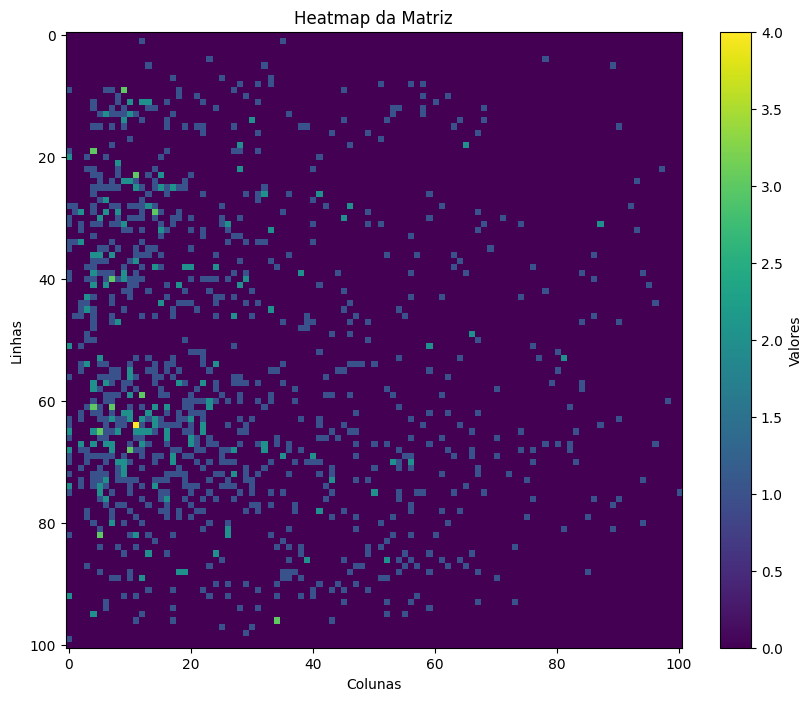

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

matriz = df_player_characteristics['heatmap_matrix_key_points'][0]
lado = int(np.sqrt(matriz.size))
matriz_2d = matriz[:lado**2].reshape((lado, lado))



plt.figure(figsize=(10, 8))
plt.imshow(matriz_2d, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Valores')
plt.title('Heatmap da Matriz')
plt.xlabel('Colunas')
plt.ylabel('Linhas')
plt.show()

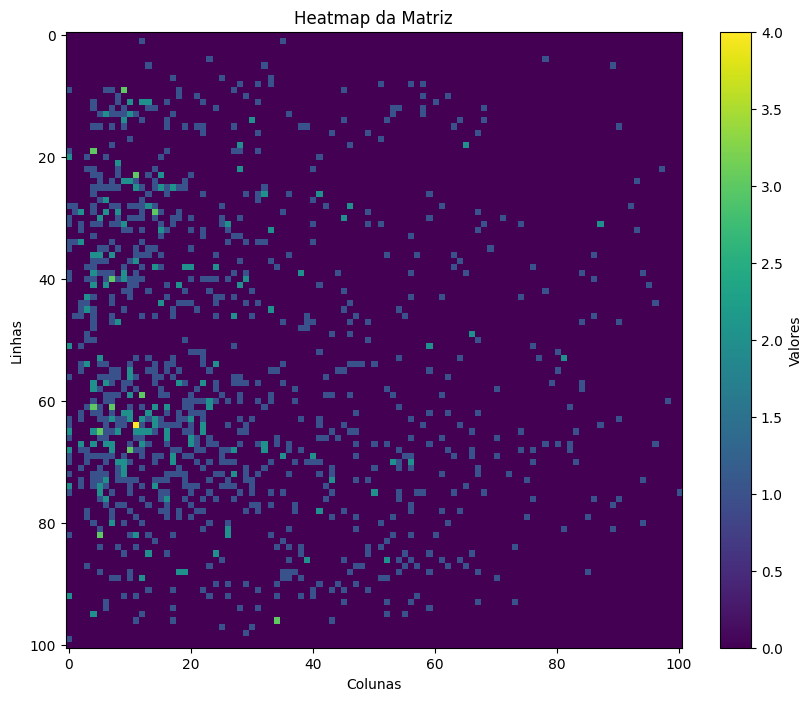

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

matriz = df_player_characteristics['heatmap_matrix'][0]
lado = int(np.sqrt(matriz.size))
matriz_2d = matriz[:lado**2].reshape((lado, lado))



plt.figure(figsize=(10, 8))
plt.imshow(matriz_2d, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Valores')
plt.title('Heatmap da Matriz')
plt.xlabel('Colunas')
plt.ylabel('Linhas')
plt.show()

In [36]:
import cv2
import numpy as np

# Carregar a imagem
imagem = cv2.imread('/home/bruno/TCC2/Notebooks/icon-256x256.png')

# Converter para escala de cinza
cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

# Criar o detector SIFT
sift = cv2.SIFT_create()

# Detectar pontos-chave e descritores
keypoints, descritores = sift.detectAndCompute(cinza, None)

# Desenhar os pontos-chave na imagem
imagem_com_keypoints = cv2.drawKeypoints(cinza, keypoints, imagem)


In [38]:
cinza

array([[224, 223, 223, ..., 227, 227, 228],
       [222, 222, 222, ..., 226, 226, 226],
       [223, 222, 223, ..., 227, 226, 228],
       ...,
       [ 19,   8,   1, ..., 192, 210, 217],
       [ 12,   1,   1, ..., 165, 183, 218],
       [  4,   2,   8, ..., 185, 179, 185]], shape=(256, 256), dtype=uint8)

In [37]:
imagem

array([[[224, 224, 224],
        [223, 223, 223],
        [223, 223, 223],
        ...,
        [227, 227, 227],
        [227, 227, 227],
        [228, 228, 228]],

       [[222, 222, 222],
        [222, 222, 222],
        [222, 222, 222],
        ...,
        [226, 226, 226],
        [226, 226, 226],
        [226, 226, 226]],

       [[223, 223, 223],
        [222, 222, 222],
        [223, 223, 223],
        ...,
        [227, 227, 227],
        [226, 226, 226],
        [228, 228, 228]],

       ...,

       [[ 19,  19,  19],
        [  8,   8,   8],
        [  1,   1,   1],
        ...,
        [192, 192, 192],
        [210, 210, 210],
        [217, 217, 217]],

       [[ 12,  12,  12],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [165, 165, 165],
        [183, 183, 183],
        [218, 218, 218]],

       [[  4,   4,   4],
        [  2,   2,   2],
        [  8,   8,   8],
        ...,
        [185, 185, 185],
        [179, 179, 179],
        [185, 185, 185]]

In [2]:
imagem_com_keypoints

array([[[224, 224, 224],
        [223, 223, 223],
        [223, 223, 223],
        ...,
        [227, 227, 227],
        [227, 227, 227],
        [228, 228, 228]],

       [[222, 222, 222],
        [222, 222, 222],
        [222, 222, 222],
        ...,
        [226, 226, 226],
        [226, 226, 226],
        [226, 226, 226]],

       [[223, 223, 223],
        [222, 222, 222],
        [223, 223, 223],
        ...,
        [227, 227, 227],
        [226, 226, 226],
        [228, 228, 228]],

       ...,

       [[ 19,  19,  19],
        [  8,   8,   8],
        [  1,   1,   1],
        ...,
        [192, 192, 192],
        [210, 210, 210],
        [217, 217, 217]],

       [[ 12,  12,  12],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [165, 165, 165],
        [183, 183, 183],
        [218, 218, 218]],

       [[  4,   4,   4],
        [  2,   2,   2],
        [  8,   8,   8],
        ...,
        [185, 185, 185],
        [179, 179, 179],
        [185, 185, 185]]

In [3]:
cinza

array([[224, 223, 223, ..., 227, 227, 228],
       [222, 222, 222, ..., 226, 226, 226],
       [223, 222, 223, ..., 227, 226, 228],
       ...,
       [ 19,   8,   1, ..., 192, 210, 217],
       [ 12,   1,   1, ..., 165, 183, 218],
       [  4,   2,   8, ..., 185, 179, 185]], shape=(256, 256), dtype=uint8)

#### Analisando a variável positions

Poucos jogadores jogam em várias posições. Acredito que se for maior que três, da para dizer que ele joga em várias posições. Só tem que identificar qual é o setor do campo

Em duas, da para identificar em qual setor do campo o cara joga. Por exemplo, se ele joga no lado direito tanto na defesa e no ataque, da para dizer que ele é do lado direito. Analisar as possibilidades para esse caso

Em uma, preencher a variável position com essa

Para quem não tem, preencher como DC o de defesa, MC o de meio campo e ST o de atacante

Todos os goleiros recebem a posição GK

In [ ]:
posicoes_distintas = set()

In [ ]:
df_player_characteristics['positions'] = df_player_characteristics['positions'].apply(eval)

In [ ]:
for x in df_player_characteristics['positions']:
    posicoes_distintas.update(x)

In [ ]:
posicoes_distintas

In [ ]:
df_player_characteristics['posicao_vazia'] = df_player_characteristics['positions'].apply(lambda x: len(x))

In [ ]:
df_player_characteristics.groupby('posicao_vazia').size()

In [ ]:
df_player_characteristics[df_player_characteristics['posicao_vazia'] == 2][:50]

### Estatísticas dos jogadores

Analises:

- Entender se jogadores outliers na idade tem algo de interessante nas suas estatísticas que pode ser aproveitado
- Entender como as estatisticas ficam em jogadores que estão abaixo da mediana e acima da mediana na variável matches

# Pré-processamento

O que posso fazer até aqui?

- Remover jogadores aposentados, falecidos e com poucos stats (olhar as análises de heatmap, position, age, matches e jogadores falecidos)
- Transformar o heatmap em algo útil
- Classificar qual tipo de jogador com base nas posições que ele ocupa
- Adicionar a altura em jogadores que não tem
- Inserir a moda para jogadores sem o pé preferencial
- Talvez agrupar a variável de altura em bins mais arredondados - ex: um grupo de 170 a 180
- Remover jogadores com mais de 60 anos
- Pensar em algo que possa transformar a variável matches em algum indice de regularidade
- Com a variável positions, posso criar uma variável que indica se o jogador joga em mais de uma posição